#### На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
#### Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [12]:
import scipy.stats as stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_excel('AB_Test_Results.xlsx')
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


У нас 10 тысяч строк данных и они все не пустые 

In [15]:
df.shape

(10000, 3)

In [16]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [17]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

У нвч нет пустых ячеек, потому не нужно производить очистку 

In [18]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

Объъемы выборок по группам отличаются незхначительно. С точки зрения объемов препятсвий для теста нет.

In [20]:
df[df['REVENUE']>0]

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


У нас только 152 юзера из обеих групп совершили покупки и принесли доход

In [21]:
df[df['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


In [22]:
df[df['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


Первичная оценка выборок показывает, что выручка по юзерам отличается, стандартное отклонение тоже.  Максимальная выручка в контрольной группе А сильно больше

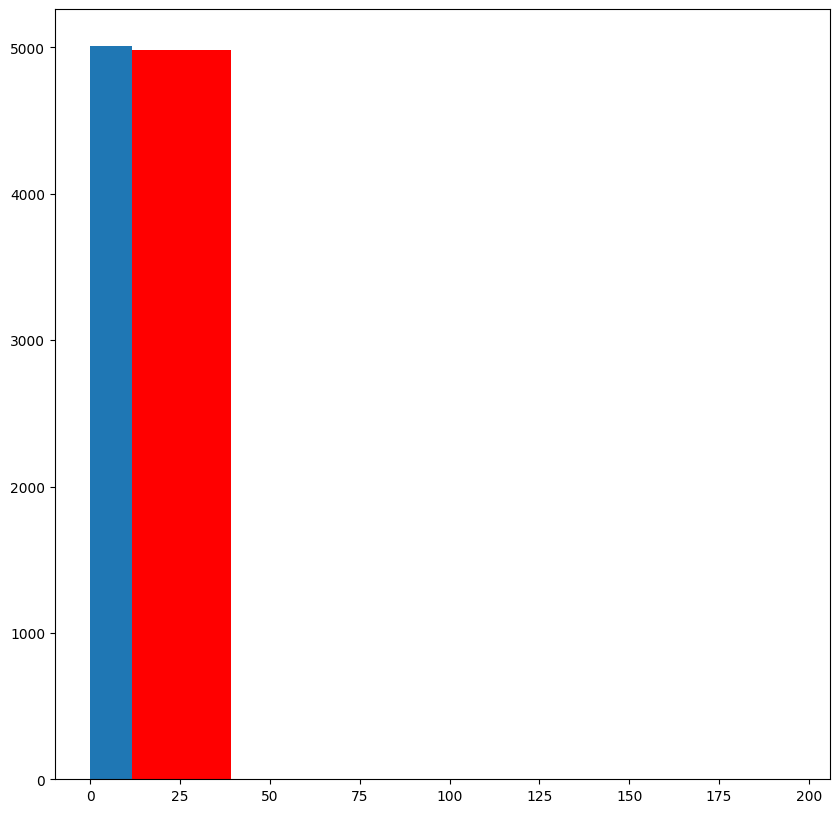

In [27]:
plt.figure(figsize=(10, 10))
control = df['REVENUE'][df['VARIANT_NAME'] == 'control']
variant = df['REVENUE'][df['VARIANT_NAME'] == 'variant']
plt.hist(control, color='r', bins=5)
plt.hist(variant,  bins=5)
plt.show()

На первый взгляд мы видим, что выручка в  контрольной группе (которая без изменений) выше, чем тестовой

In [30]:

print(stats.shapiro(control))
print(stats.shapiro(variant))

ShapiroResult(statistic=0.018331527709960938, pvalue=0.0)
ShapiroResult(statistic=0.027033090591430664, pvalue=0.0)


Мы видим, что p-value обеких групп свидетельствует нам об отсутсвии нормальности распределения. Поскольку у нас группы в размере 5 тыс мы можем использолвать тест на нормальность Шапиро-Уилка. Поскольку выборка меньше 100 тыс и отсутсвует нормальность распределения для оценки значимости стат различий мы используем непараметрический тест для 2 независимых выборок Манна-Уитни

In [31]:
stats.mannwhitneyu(control, variant)

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)

p-value двух групп нам говорит, что статистических различий между группами нет, то есть мы не получили никакой пользы от внесенных изменений, и нам рекомендуется использовать исходный вариант. 

Для проверки расчитаем мощность теста:

In [35]:
s1= control.values
s2= variant.values
C_mean = s1.mean()
T_mean = s2.mean()
C_std = s1.std()
T_std = s2.std()
S = np.sqrt((T_std**2 + C_std **2)/ 2)
ef =float((T_mean-C_mean)/ S) 
print(ef)

-0.025398300337756648


Исходя итз цифры 25,3 % - мы видим очень слабую мощность, то есть у нас очень высока вероятность ошибки второго рода, то есть мы можем не увидить различия там, где они действительно есть

Рекомендуется перезапустить тест, предварительно более детельно проработав сплит систему и рассчитав нужный объем выборок и, соответсвенно, длительности теста.